In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [4]:
# Load stock data (assuming you have a CSV file with historical stock prices)
data = pd.read_csv('stock_data.csv')


In [5]:
# Preprocess the data
# Assuming the 'Close' column contains the closing prices
close_prices = data['close'].values.reshape(-1, 1)

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)


In [7]:
# Define a function to create the input dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


In [8]:
# Define the number of time steps
time_steps = 60  # Use the past 60 days' data to predict the next day's price


In [9]:
# Create the dataset
X, y = create_dataset(scaled_close_prices, time_steps)


In [10]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).float()


In [11]:
# Split the dataset into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X_tensor[:split_index], X_tensor[split_index:]
y_train, y_test = y_tensor[:split_index], y_tensor[split_index:]

In [12]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)


In [15]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [17]:
# Reshape input data for LSTM
X_train = X_train.view(-1, time_steps, 1)
X_test = X_test.view(-1, time_steps, 1)

In [18]:
# Train the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([557])) that is different to the input size (torch.Size([557, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.1056
Epoch [20/100], Loss: 0.0583
Epoch [30/100], Loss: 0.0613
Epoch [40/100], Loss: 0.0599
Epoch [50/100], Loss: 0.0585
Epoch [60/100], Loss: 0.0578
Epoch [70/100], Loss: 0.0577
Epoch [80/100], Loss: 0.0576
Epoch [90/100], Loss: 0.0576
Epoch [100/100], Loss: 0.0576


In [19]:
# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    y_pred = scaler.inverse_transform(y_pred.cpu().numpy())

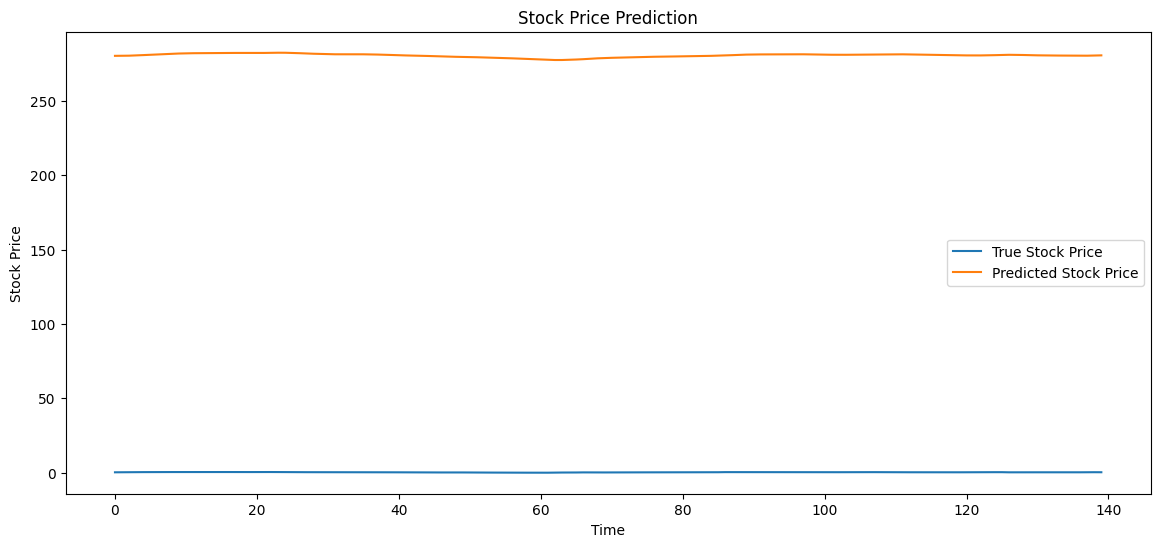

In [20]:
# Visualize the results
plt.figure(figsize=(14, 6))
plt.plot(y_test.numpy(), label='True Stock Price')
plt.plot(y_pred, label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()